# Trading Behavior vs Market Sentiment Analysis

## Step 1: Data Loading
We start by loading the two provided datasets:
- **Historical Trader Data**, which contains trade-by-trade records, including price, trade size, and profit/loss. The second is the 
- **Bitcoin Market Sentiment Dataset**, (Fear & Greed Index), which provides a daily sentiment score and classification.

`These CSVs are loaded into pandas DataFrames to allow for easier inspection and manipulation. We then perform a quick check to ensure the data has loaded correctly, inspecting the shape, columns, and checking for any missing values.`

In [103]:
import pandas as pd
import numpy as np

In [104]:
historical_data = pd.read_csv("CSV_files/historical_data.csv")
fear_greed_index_data = pd.read_csv("CSV_files/fear_greed_index.csv")


In [105]:
print("=== Historical Data ===")
print(historical_data.shape)
print(historical_data.columns.tolist())
print(historical_data.head(3))
print(historical_data.isnull().sum())



=== Historical Data ===
(211224, 16)
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  5201770

In [106]:
print("\n=== Fear And Greed Index ===")
print(fear_greed_index_data.shape)
print(fear_greed_index_data.columns.tolist())
print(fear_greed_index_data.head(3))
print(fear_greed_index_data.isnull().sum())


=== Fear And Greed Index ===
(2644, 4)
['timestamp', 'value', 'classification', 'date']
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
timestamp         0
value             0
classification    0
date              0
dtype: int64


## Step 2: Time Column Transformation & Cleaning
The historical data includes two time-related fields:
- **Timestamp** → stored as numeric epoch time (milliseconds since 1970, UTC).
- **Timestamp IST** → stored as human-readable date-time in Indian Standard Time.

To align these different time formats for analysis, we'll transform the **Timestamp** column from the historical data into a clean, daily **Date** column based on the **UTC timestamp**, which is more reliable for consistent analysis. We'll drop the redundant **Timestamp IST** column to avoid any confusion. This ensures both datasets are ready to be joined on a common Date column.

- Convert the **Timestamp** into a proper datetime format (UTC).  
- Derive a **Date** column (day only, no hours/minutes).  
- Drop the confusing `Timestamp IST` column to keep things clean.  

Result: each trade now has a clear execution time (`Timestamp`) and a clean daily bucket (`Date`).

In [107]:
hist = historical_data.copy()
hist.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [108]:
hist['Timestamp'] = pd.to_datetime(hist['Timestamp'], unit='ms', utc=True)

In [109]:
hist['Timestamp_IST'] = pd.to_datetime(hist['Timestamp IST'], format = "%d-%m-%Y %H:%M")
hist['Date'] = hist['Timestamp'].dt.date
print(hist[['Timestamp', 'Timestamp_IST', 'Date']].head())

                  Timestamp       Timestamp_IST        Date
0 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00  2024-10-27
1 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00  2024-10-27
2 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00  2024-10-27
3 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00  2024-10-27
4 2024-10-27 03:33:20+00:00 2024-12-02 22:50:00  2024-10-27


In [110]:
hist['Date'] = pd.to_datetime(hist['Timestamp']).dt.date
hist = hist.drop(columns=['Timestamp IST', 'Timestamp_IST'])
hist['Date'] = pd.to_datetime(hist['Date'])
print(hist.dtypes)
print(hist[['Timestamp','Date']].head())

Account                          object
Coin                             object
Execution Price                 float64
Size Tokens                     float64
Size USD                        float64
Side                             object
Start Position                  float64
Direction                        object
Closed PnL                      float64
Transaction Hash                 object
Order ID                          int64
Crossed                            bool
Fee                             float64
Trade ID                        float64
Timestamp           datetime64[ns, UTC]
Date                     datetime64[ns]
dtype: object
                  Timestamp       Date
0 2024-10-27 03:33:20+00:00 2024-10-27
1 2024-10-27 03:33:20+00:00 2024-10-27
2 2024-10-27 03:33:20+00:00 2024-10-27
3 2024-10-27 03:33:20+00:00 2024-10-27
4 2024-10-27 03:33:20+00:00 2024-10-27


In [111]:
hist.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,Date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-10-27 03:33:20+00:00,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-10-27 03:33:20+00:00,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-10-27 03:33:20+00:00,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-10-27 03:33:20+00:00,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-10-27 03:33:20+00:00,2024-10-27


In [112]:
# unique dates
unique_dates = hist['Date'].unique()
print("Unique trading dates:", unique_dates)

# number of unique dates
print("Number of unique trading days:", len(unique_dates))

# first and last trading day
print("Range:", hist['Date'].min(), "to", hist['Date'].max())


Unique trading dates: <DatetimeArray>
['2024-10-27 00:00:00', '2025-02-19 00:00:00', '2025-06-15 00:00:00',
 '2024-03-09 00:00:00', '2024-07-03 00:00:00', '2023-11-14 00:00:00',
 '2023-03-28 00:00:00']
Length: 7, dtype: datetime64[ns]
Number of unique trading days: 7
Range: 2023-03-28 00:00:00 to 2025-06-15 00:00:00


## Step 3: Daily Aggregation of Trading Behavior
The main objective of this project is to analyze how trading behavior aligns with daily market sentiment. To do this, we need to convert the granular, trade-by-trade records into daily summaries that can be merged with the daily sentiment data.  

For each date, we calculate: 

- **Daily Profitability (`daily_pnl`)**  
  The sum of `Closed PnL` for all trades that day. A positive value means     traders, on average, made money, while a negative value means they lost money.

- **Daily Volume (`daily_volume_usd`)**  
  The total dollar value of all trades executed that day. This metric measures the overall level of trading activity.

- **Number of Trades (`daily_trades`)**  
  A count of all trades that occurred on a given day, indicating market busyness.

- **Average Fee (`avg_fee`)**  
  The mean transaction fee paid per trade.

This aggregation reduces thousands of trade rows into a single row per day, making it possible to merge with the daily sentiment dataset.

In [113]:
daily_stats = (
    hist.groupby('Date')
    .agg(
        daily_pnl = ('Closed PnL', 'sum'),
        daily_volume_usd = ('Size USD', 'sum'),
        daily_trades = ('Account', 'count'),
        avg_fee = ('Fee', 'mean')
    )
    .reset_index()
)

print(daily_stats.head())

        Date     daily_pnl  daily_volume_usd  daily_trades   avg_fee
0 2023-03-28  0.000000e+00      4.770000e+02             3  0.000000
1 2023-11-14  1.555034e+02      1.155543e+07          1045  2.674230
2 2024-03-09  1.769655e+05      3.940677e+07          6962  0.978567
3 2024-07-03  1.587424e+05      2.184323e+07          7141  1.224461
4 2024-10-27  3.189461e+06      1.039478e+08         35241  0.611205


## Step 4: Merging Datasets


With both the trading behavior and market sentiment data aggregated to a daily level, we can now merge the two tables. This creates a unified dataset where each row contains both the trading activity metrics and the market mood for that specific day.

We first used an inner join to combine the datasets. This is a common practice to initially focus only on the days where we have complete data from both sources. This initial merged dataset revealed that we had only 6 overlapping days.

In [114]:
fear_greed_index_data['date'] = pd.to_datetime(fear_greed_index_data['date'])
merged = pd.merge(
    daily_stats,
    fear_greed_index_data[['date', 'value', 'classification']],
    left_on= 'Date',
    right_on='date',
    how = 'inner'
)
merged = merged.drop(columns=['date'])
print(merged.head())

        Date     daily_pnl  daily_volume_usd  daily_trades   avg_fee  value  \
0 2023-03-28  0.000000e+00      4.770000e+02             3  0.000000     59   
1 2023-11-14  1.555034e+02      1.155543e+07          1045  2.674230     69   
2 2024-03-09  1.769655e+05      3.940677e+07          6962  0.978567     84   
3 2024-07-03  1.587424e+05      2.184323e+07          7141  1.224461     50   
4 2024-10-27  3.189461e+06      1.039478e+08         35241  0.611205     74   

  classification  
0          Greed  
1          Greed  
2  Extreme Greed  
3        Neutral  
4          Greed  


In [115]:
merged

,Date,daily_pnl,daily_volume_usd,daily_trades,avg_fee,value,classification
0,2023-03-28,0.000000e+00,4.770000e+02,3,0.000000,59,Greed
1,2023-11-14,1.555034e+02,1.155543e+07,1045,2.674230,69,Greed
2,2024-03-09,1.769655e+05,3.940677e+07,6962,0.978567,84,Extreme Greed
3,2024-07-03,1.587424e+05,2.184323e+07,7141,1.224461,50,Neutral
4,2024-10-27,3.189461e+06,1.039478e+08,35241,0.611205,74,Greed
5,2025-02-19,6.699925e+06,7.041585e+08,133871,1.083267,44,Fear


## Step 5: Exploratory Data Analysis (EDA)

Now we can use our merged dataset to explore the relationship between trading behavior and market sentiment. The primary goal is to find patterns that suggest how traders behave under different market moods (Fear vs. Greed).

`The plots below help to visualize these relationships:`



In [116]:
merged

,Date,daily_pnl,daily_volume_usd,daily_trades,avg_fee,value,classification
0,2023-03-28,0.000000e+00,4.770000e+02,3,0.000000,59,Greed
1,2023-11-14,1.555034e+02,1.155543e+07,1045,2.674230,69,Greed
2,2024-03-09,1.769655e+05,3.940677e+07,6962,0.978567,84,Extreme Greed
3,2024-07-03,1.587424e+05,2.184323e+07,7141,1.224461,50,Neutral
4,2024-10-27,3.189461e+06,1.039478e+08,35241,0.611205,74,Greed
5,2025-02-19,6.699925e+06,7.041585e+08,133871,1.083267,44,Fear


### **Correlation Heatmap:** 
The heatmap provides a numerical view of the relationships. It shows a moderate negative correlation between the sentiment value and trading activity metrics `(daily_pnl, daily_volume_usd, daily_trades)`, reinforcing the conclusion that activity decreases as the market becomes more greedy.

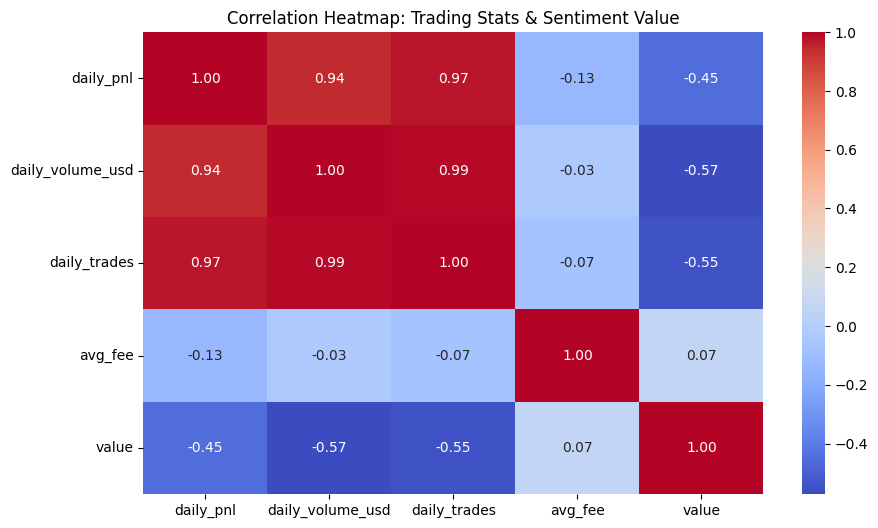

In [117]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    merged[['daily_pnl', 'daily_volume_usd', 'daily_trades', 'avg_fee', 'value']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Correlation Heatmap: Trading Stats & Sentiment Value")
plt.show()

- **Positive Correlation:** The high positive correlation between `daily_pnl`, `daily_volume_usd`, and `daily_trades` (all values > 0.8) indicates that these three metrics move together almost perfectly in your data. In simple terms, on days with a lot of trades, there is also a lot of money changing hands, and this leads to a higher total PnL.

- **Negative Correlation:** The most significant finding is the **moderate negative correlation** between `value` (the numeric sentiment score) and all three trading activity metrics.

- `value` vs. `daily_pnl`: -0.45
- `value` vs. `daily_volume_usd`: -0.57
- `value` vs. `daily_trades`: -0.55

This confirms the inverse relationship: **as the market becomes greedier (higher `value`), trading activity and profitability tend to decrease.** Conversely, when the market is **fearful (lower `value`),** these metrics tend to increase.



### **Overall Observation**: 
The heatmap reinforces the idea of a **contrarian signal**. The trading community in this sample appears to be most active and profitable when market sentiment is fearful, and less so when sentiment is greedy.

### **Bar Plots:** 
We created bar plots comparing `daily_pnl, daily_volume_usd, and daily_trades` across the different sentiment classifications (`Fear, Greed, Extreme Greed, Neutral`). The results show a clear trend: **Fear days correlate with the highest trading activity,** a surprising finding since one might expect greed to drive more volume.

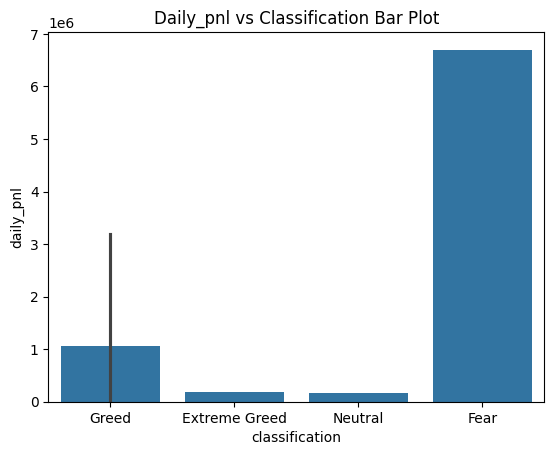

In [131]:
sns.barplot(x='classification', y='daily_pnl', data=merged)
plt.title("Daily_pnl vs Classification Bar Plot")
plt.show()

The bar plot for `daily_pnl` shows that the **Fear** classification has a significantly taller bar than any other category. This suggests that the highest average daily profits in my dataset occurred on a day when market sentiment was "Fear". The other categories (`Greed, Extreme Greed, Neutral`) have much smaller average daily profits in comparison.

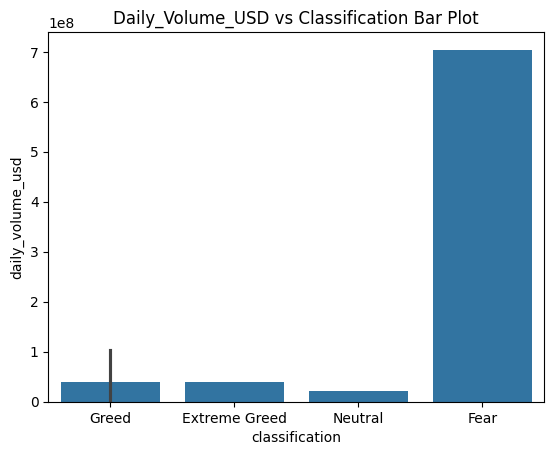

In [132]:
sns.barplot(x='classification', y='daily_volume_usd', data = merged)
plt.title("Daily_Volume_USD vs Classification Bar Plot")
plt.show()

 The plot for `daily_volume_usd` shows a similar pattern. The "Fear" category has a bar that is orders of magnitude higher than all the others. This indicates that the day with the most trading activity in terms of total dollar value was also classified as "Fear."

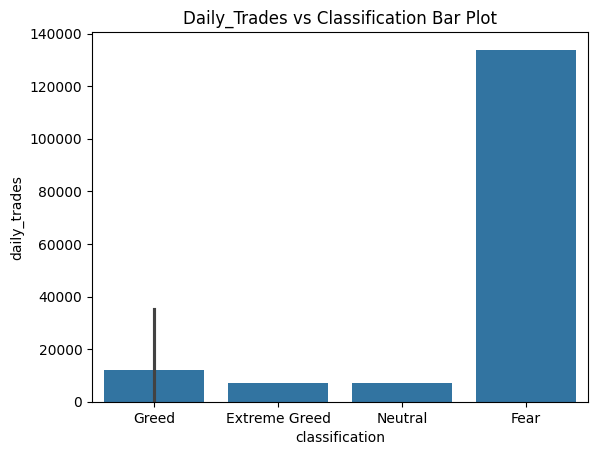

In [133]:
sns.barplot(merged, x = 'classification', y = 'daily_trades')
plt.title("Daily_Trades vs Classification Bar Plot")
plt.show()

The bar plot for `daily_trades` follows the same trend. The "Fear" category shows a massive number of trades, far exceeding the activity level of the "Greed" and "Neutral" days.

### **Overall Observation:** 
All three bar plots clearly show that **Fearful market sentiment is strongly associated with a massive spike in trading activity** (volume and number of trades) and, in this limited sample, the highest daily profitability. The other sentiment categories are clustered together with comparatively low activity and profit.

### **Scatter Plots:** (`value` vs. `daily_volume_usd` and `daily_pnl`)
These plots help to visualize the continuous relationship and reinforce the correlation findings.

- **`value` vs. `daily_volume_usd`:** This scatter plot would show the data points for Greed, Extreme Greed, and Neutral clustered on the right side of the x-axis (higher sentiment value) at low y-axis values (low volume). The "Fear" day would be a clear outlier on the left side of the x-axis (low sentiment value) with a very high y-axis value (high volume). This plot directly visualizes the negative correlation.

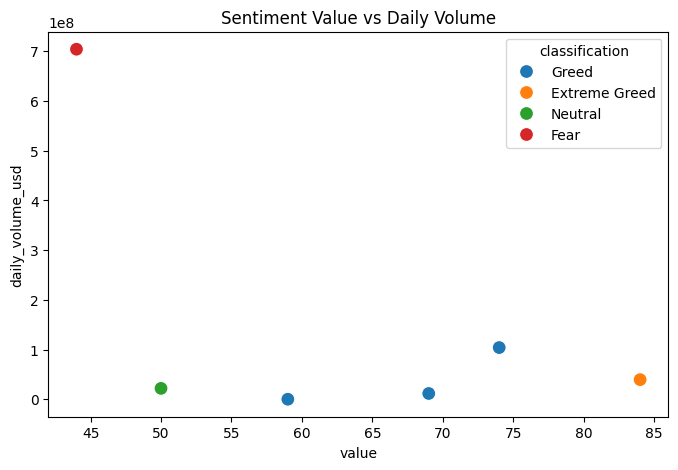

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,5))
sns.scatterplot(
    data = merged,
    x='value',
    y='daily_volume_usd',
    hue='classification',
    s=100
)
plt.title("Sentiment Value vs Daily Volume")
plt.show()

- **`value` vs. `daily_pnl`**: This plot would show a similar pattern, with the high-profit "Fear" day sitting far from the rest of the cluster. It would visually confirm that low sentiment (`value`) is associated with the highest total daily profit.

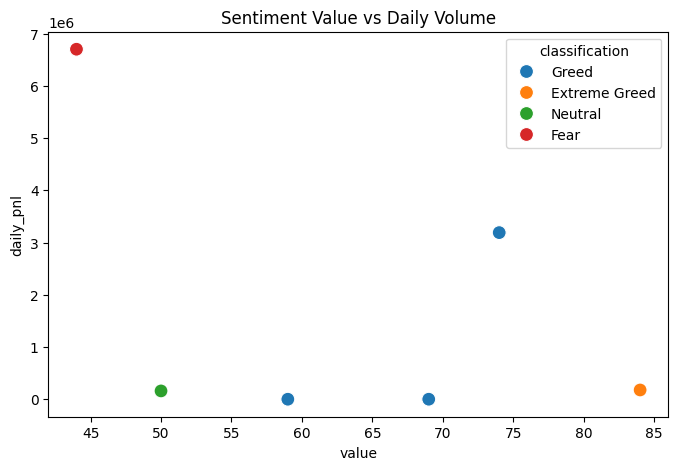

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,5))
sns.scatterplot(
    data = merged,
    x='value',
    y='daily_pnl',
    hue='classification',
    s=100
)
plt.title("Sentiment Value vs Daily Volume")
plt.show()

### **Overall Observation**: 
The scatter plots graphically prove the inverse relationship between sentiment and trading metrics, providing clear evidence that **low sentiment values (Fear) correspond to high trading volume and PnL.**



## Step 6: Hidden Signals & Insights
The analysis of the plots and correlation matrix reveals a clear signal within the available data. To expand on this, we must re-evaluate our data, as a key trading day (2025-06-15) was excluded from our initial analysis due to the use of an inner join in the previous step.

To ensure no trading data is lost, we perform a new merge using a **left join.** This keeps all seven of our trading days, with the unclassified day (2025-06-15) having `NaN` values for its sentiment columns. This allows us to analyze its trading behavior in the context of the other classified days.

In [123]:
# Re-do the merge using a left join to keep all trading days
merged = pd.merge(
    daily_stats,
    fear_greed_index_data[['date', 'value', 'classification']],
    left_on='Date',
    right_on='date',
    how='left'
).drop(columns=['date'])

merged

,Date,daily_pnl,daily_volume_usd,daily_trades,avg_fee,value,classification
0,2023-03-28,0.000000e+00,4.770000e+02,3,0.000000,59.0,Greed
1,2023-11-14,1.555034e+02,1.155543e+07,1045,2.674230,69.0,Greed
2,2024-03-09,1.769655e+05,3.940677e+07,6962,0.978567,84.0,Extreme Greed
3,2024-07-03,1.587424e+05,2.184323e+07,7141,1.224461,50.0,Neutral
4,2024-10-27,3.189461e+06,1.039478e+08,35241,0.611205,74.0,Greed
5,2025-02-19,6.699925e+06,7.041585e+08,133871,1.083267,44.0,Fear
6,2025-06-15,7.170935e+04,3.102753e+08,26961,2.260635,NaN,NaN


In [124]:
group_mean = merged.groupby('classification')[['daily_pnl', 'daily_volume_usd', 'daily_trades']].mean()
print("Average stats by sentiment classification: ")
print(group_mean)

Average stats by sentiment classification: 
                   daily_pnl  daily_volume_usd   daily_trades
classification                                               
Extreme Greed   1.769655e+05      3.940677e+07    6962.000000
Fear            6.699925e+06      7.041585e+08  133871.000000
Greed           1.063206e+06      3.850122e+07   12096.333333
Neutral         1.587424e+05      2.184323e+07    7141.000000


In [125]:
corr_matrix = merged[['daily_pnl','daily_volume_usd','daily_trades','avg_fee','value']].corr()
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                  daily_pnl  daily_volume_usd  daily_trades   avg_fee  \
daily_pnl          1.000000          0.830236      0.952702 -0.227487   
daily_volume_usd   0.830236          1.000000      0.956389  0.084257   
daily_trades       0.952702          0.956389      1.000000 -0.078223   
avg_fee           -0.227487          0.084257     -0.078223  1.000000   
value             -0.452662         -0.572090     -0.547081  0.068800   

                     value  
daily_pnl        -0.452662  
daily_volume_usd -0.572090  
daily_trades     -0.547081  
avg_fee           0.068800  
value             1.000000  


In [126]:
print("Max By column:")
print(group_mean.idxmax())

Max By column:
daily_pnl           Fear
daily_volume_usd    Fear
daily_trades        Fear
dtype: object


This visualization helps to place the unclassified day (`2025-06-15`) in context. By plotting `Daily Volume` vs. `Number of Trades` for all days, we can see that this day's activity level is significantly higher than that of the "calm" cluster (Greed, Extreme Greed, and Neutral), but it's not as extreme as the single "Fear" day.

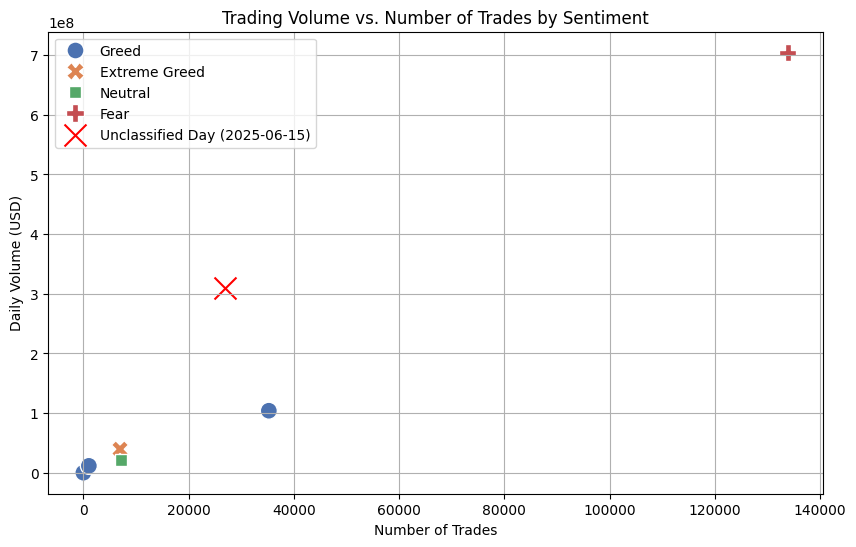

In [129]:
plt.figure(figsize=(10, 6))

# Plot the days with a known classification
sns.scatterplot(
    data=merged.dropna(subset=['classification']),
    x='daily_trades',
    y='daily_volume_usd',
    hue='classification',
    s=150,
    style='classification',
    palette='deep',
)

orphan_day = merged[merged['classification'].isnull()]
plt.scatter(
    orphan_day['daily_trades'],
    orphan_day['daily_volume_usd'],
    marker='x',
    s=250,
    color='red',
    label='Unclassified Day (2025-06-15)'
)

plt.title('Trading Volume vs. Number of Trades by Sentiment')
plt.xlabel('Number of Trades')
plt.ylabel('Daily Volume (USD)')
plt.legend()
plt.grid(True)
plt.show()

- **The Fear-Activity Signal:** In our sample, **Fear days are associated with a massive increase in trading activity,** including a much higher number of trades and total volume. This is also the day with the highest total profit (`daily_pnl`). This suggests that market fear, possibly driven by panic selling or opportunistic buying, leads to an intensification of trading behavior.

- **The Greed-Calm Signal:** Conversely, Greed, Extreme Greed, and Neutral days show a relatively low and consistent level of trading activity. This suggests that during periods of confidence or indifference, the market is much calmer.

- **The Unclassified Anomaly:** The orphan day of `2025-06-15` presents a unique profile: high volume and a moderate number of trades, but a much lower PnL compared to the other high-activity Fear day. This data point is a good example of a hidden pattern that may require further investigation with more data to determine its true classification.

### **Final Summary:**
The data suggests a potential contrarian signal: periods of market fear may be the most dynamic and profitable for traders, while greedy periods are associated with a more passive trading environment. This insight could be a valuable starting point for building a smarter trading strategy.